In [1]:
#Importing the necessary libraries
from functions_audio_model import *
from moviepy.editor import VideoFileClip
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import zoom
import numpy as np
import os
import json
import librosa
import timm
import torchaudio
import numpy as np
import torch
from torch.utils.data import Dataset
import os

In [ ]:
#Extraction of the data from the mp4 files and saving them in the audio_files directory

#Provided Videos
video_dir = 'utterances_final/'

#Directory for saving the extracted audio
audio_dir = 'data/audio/F/'

video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

for video_file in video_files:
    clip = VideoFileClip(os.path.join(video_dir, video_file))
    
    #Extraction of the audio and saving in the audio_files directory
    audio_file = video_file.replace('.mp4', '.wav')
    clip.audio.write_audiofile(os.path.join(audio_dir, audio_file))

In [18]:


bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
wvmodel = bundle.get_model()

wv,sr = torchaudio.load('data/audio/F')

with torch.inference_mode():
    feats, _ = wvmodel.extract_features(torch.unsqueeze(wv[0], dim=0))





In [32]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os

class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, labels):
        self.embedding_dir = embedding_dir
        self.file_list = [f for f in os.listdir(embedding_dir) if f.endswith('_w2V2.npy')]
        self.labels = labels  #dictionary mapping base file names to labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file (without the color channel)
        
        base_name = self.file_list[idx].replace('_w2V2.npy', '')

        embedding = np.load(os.path.join(self.embedding_dir, base_name + '_w2V2.npy'))
    
        #Label
        label = self.labels[base_name]
      

        #print(f"embedding before mean .shape = {embedding.shape}")
        embedding = torch.mean(torch.from_numpy(embedding), dim=1)
        #print(f"embedding after mean.shape = {embedding.shape}")
        

        return embedding, label

In [15]:
with open('data/audio/labels_F.json', 'r') as file:
    labelsF = json.load(file)

In [16]:
labelsF

{'1_70': 1,
 '1_537': 1,
 '1_1470': 0,
 '1_1973': 1,
 '1_1987': 1,
 '1_2464': 1,
 '1_2792': 0,
 '1_3348': 0,
 '1_3419': 1,
 '1_3573': 1,
 '1_3649': 0,
 '1_3660': 1,
 '1_4544': 0,
 '1_4552': 0,
 '1_4576': 0,
 '1_5134': 1,
 '1_5166': 1,
 '1_5169': 0,
 '1_5211': 1,
 '1_5496': 1,
 '1_5751': 0,
 '1_5758': 1,
 '1_5880': 1,
 '1_6039': 0,
 '1_6188': 1,
 '1_6221': 1,
 '1_6427': 1,
 '1_6769': 1,
 '1_6835': 0,
 '1_7395': 1,
 '1_7400': 0,
 '1_7443': 0,
 '1_7445': 0,
 '1_7675': 0,
 '1_8052': 1,
 '1_8185': 0,
 '1_8717': 1,
 '1_8746': 1,
 '1_8749': 1,
 '1_8827': 1,
 '1_9972': 1,
 '1_9993': 1,
 '1_10009': 0,
 '1_10495': 1,
 '1_10748': 1,
 '1_10797': 0,
 '1_10853': 0,
 '1_11006': 1,
 '1_11021': 1,
 '1_11042': 0,
 '1_11098': 1,
 '1_11201': 0,
 '1_11232': 1,
 '1_11242': 1,
 '1_11322': 1,
 '1_11439': 1,
 '1_11485': 0,
 '1_11697': 1,
 '1_11773': 1,
 '1_11889': 0,
 '1_11928': 0,
 '1_12331': 0,
 '2_279': 1,
 '2_549': 0,
 '2_389': 1,
 '2_440': 1,
 '2_88': 0,
 '2_154': 0,
 '2_163': 1,
 '2_267': 0,
 '2_284': 0,

In [33]:
embeddings_dir = 'embeddingsF/'

In [82]:
batchsize = 8
learning_rate = 0.001
N_EPOCHS = 50


In [83]:
dataset = EmbeddingDataset(embeddings_dir, labelsF)

dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

In [84]:
next(iter(dataloader))

[tensor([[[ 0.1427,  0.0430,  0.0697,  ...,  0.0275, -0.0305, -0.1054]],
 
         [[ 0.1544,  0.1317,  0.1935,  ...,  0.2275,  0.1243, -0.2560]],
 
         [[ 0.1472,  0.0915,  0.1083,  ...,  0.0620, -0.0758, -0.2563]],
 
         ...,
 
         [[ 0.2562,  0.0591,  0.0886,  ..., -0.0106,  0.0327, -0.2440]],
 
         [[ 0.1413,  0.0961,  0.0893,  ...,  0.0651,  0.0332, -0.1939]],
 
         [[ 0.1365,  0.1857,  0.0218,  ...,  0.0484,  0.0241, -0.1829]]]),
 tensor([0, 0, 0, 0, 0, 1, 0, 0])]

In [85]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # Define a linear layer
        self.linear = nn.Linear(768, 2)
    
    def forward(self, x):
        # Forward pass through the linear layer
        out = self.linear(x)
        return out


In [86]:
#last layer -> classification head
num_ftrs = 768

#Binary Classification -> Sarcasm or not
num_classes = 2 

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()
#Replace the last layer with a new one
#model.head = nn.Linear(num_ftrs, num_classes)
#model_head = Classifier()


In [87]:
#Splitting the dataset into training and testing data

train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

train Loss: 0.3938,  ACC: 0.8274, F1-weighted: 0.7945


100%|██████████| 6/6 [00:00<00:00, 108.75it/s]


eval Loss: 0.4849,  ACC: 0.8333, F1-weighted: 0.8228


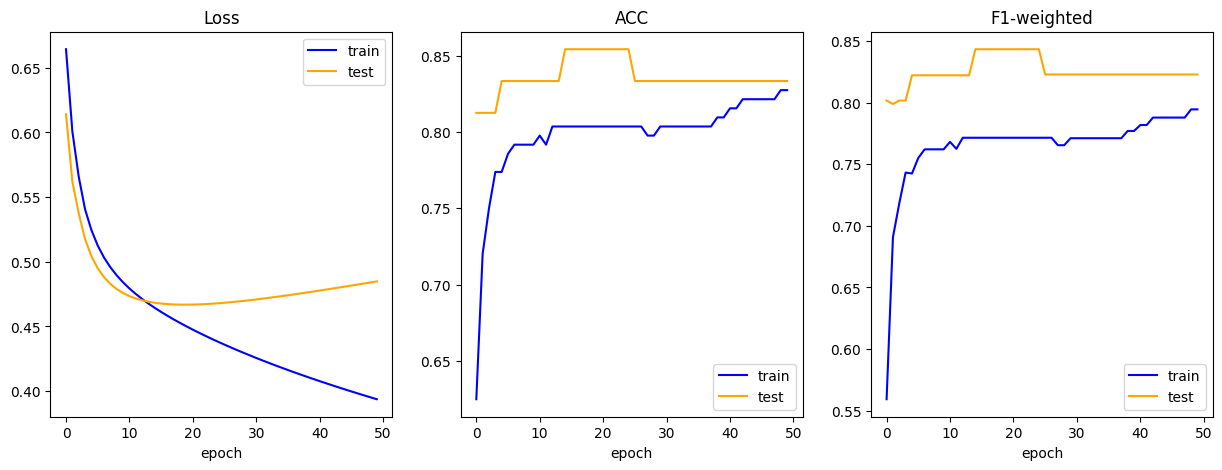

In [88]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
#model.to(device)

model_head = Classifier()
# Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Use BCEWithLogitsLoss for binary classification
#criterion = nn.BCEWithLogitsLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}
#model_head = Classifier()
model_head = Classifier()
# Create the optimizer
optimizer = torch.optim.AdamW(model_head.parameters(), lr=learning_rate)

# Train the model
# You need to replace `train_cycle` with your actual training function
train_metrics_log, test_metrics_log = train_cycle(model_head, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'beit_model_spectrograms.pth')
